<a href="https://colab.research.google.com/github/SergeyShchus/Automatic_GIS/blob/master/Notebook/Geopandas/Case_hospital_districts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
# Install OpticalRS. This also installs GeoPandas because GeoPandas is a dependency of OpticalRS
!apt-get install software-properties-common python-software-properties > /dev/null
!add-apt-repository ppa:ubuntugis/ppa -y > /dev/null
!apt-get update > /dev/null
!apt-get install -y --fix-missing python-gdal gdal-bin libgdal-dev > /dev/null
!pip2 install OpticalRS > /dev/null

! pip install geopandas

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from google.colab import drive
drive.mount('/content/gdrive')

E: Package 'python-software-properties' has no installation candidate
Extracting templates from packages: 100%
     |████████████████████████████████| 1.0MB 4.2MB/s 
     |████████████████████████████████| 14.8MB 11.7MB/s 
     |████████████████████████████████| 6.5MB 39.9MB/s 
Mounted at /content/gdrive


In [2]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

In [3]:
# For available features, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
geodata = gpd.read_file(url)

In [4]:
geodata.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2021,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364150.540 7..."
1,kunta1000k.2,009,2021,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 380556.177 7..."
2,kunta1000k.3,010,2021,Alavus,Alavo,Alavus,"POLYGON ((343298.204 6961570.195, 340572.015 6..."
3,kunta1000k.4,016,2021,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 432732.949 6..."
4,kunta1000k.5,018,2021,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 425751.505 6..."


In [5]:
# Check length (there are 310 municipalities in Finland in 2020)
len(geodata)

309

In [6]:
#Select and rename columns
geodata.rename(columns={'kunta':'code'}, inplace=True)
geodata = geodata[['code','name', 'geometry']]
geodata.head()

,code,name,geometry
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364150.540 7..."
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 380556.177 7..."
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 340572.015 6..."
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 432732.949 6..."
4,018,Askola,"POLYGON ((426631.036 6720528.076, 425751.505 6..."


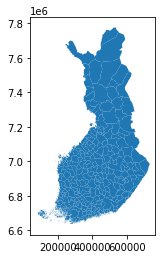

In [7]:
geodata.plot()

In [8]:
geodata.dtypes

code          object
name          object
geometry    geometry
dtype: object

In [9]:
!pip install xlrd

In [10]:
# Read in the excel spreadsheet
data = pd.read_excel(r"/content/Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)


In [11]:
data.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
0,NaN,NaN,NaN,NaN,NaN,NaN
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0


In [12]:
data.dropna(inplace=True)


In [13]:
len(data)

294

In [14]:
# Rename columns from Finnish to English 
data.rename(columns={"kunta-\nkoodi":"code", 'sairaanhoitopiiri':'healthCareDistrict'}, inplace=True)

# Select only useful columns
data = data[['code','healthCareDistrict']]

In [15]:
data

,code,healthCareDistrict
1,20.0,Pirkanmaa
2,5.0,Etelä-Pohjanmaa
3,9.0,Pohjois-Pohjanmaa
4,10.0,Etelä-Pohjanmaa
5,16.0,Päijät-Häme
...,...,...
290,977.0,Pohjois-Pohjanmaa
291,980.0,Pirkanmaa
292,981.0,Kanta-Häme
293,989.0,Etelä-Pohjanmaa


In [16]:
data.dtypes

code                  float64
healthCareDistrict     object
dtype: object

In [17]:
# Example using one code
number = data.at[1, "code"]
number

20.0

In [18]:
# Conver this number to character string 020
"0" + str(int(number))

'020'

In [20]:
# Truncate and convert to character string
data["code"] = data["code"].astype(int).astype('str')

# Add missing zeros to municipality codes
data["code"] = data["code"].apply(lambda x: "00" + x if len(x)==1 else x)
data["code"] = data["code"].apply(lambda x: "0" + x if len(x)==2 else x)

In [21]:
data.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


In [22]:
# Merge health district info to geodata using "code" as the common key
geodata = geodata.merge(data, on="code", how="left")

In [23]:
geodata

,code,name,geometry,healthCareDistrict
0,005,Alajärvi,"POLYGON ((366787.924 7001300.583, 364150.540 7...",Etelä-Pohjanmaa
1,009,Alavieska,"POLYGON ((382543.364 7120022.976, 380556.177 7...",Pohjois-Pohjanmaa
2,010,Alavus,"POLYGON ((343298.204 6961570.195, 340572.015 6...",Etelä-Pohjanmaa
3,016,Asikkala,"POLYGON ((436139.680 6798279.085, 432732.949 6...",Päijät-Häme
4,018,Askola,"POLYGON ((426631.036 6720528.076, 425751.505 6...",HUS
...,...,...,...,...
304,977,Ylivieska,"POLYGON ((398010.991 7110887.267, 392464.690 7...",Pohjois-Pohjanmaa
305,980,Ylöjärvi,"POLYGON ((313738.511 6896936.100, 311165.511 6...",Pirkanmaa
306,981,Ypäjä,"POLYGON ((297451.456 6756204.328, 291432.640 6...",Kanta-Häme
307,989,Ähtäri,"POLYGON ((348733.187 6959704.551, 347302.684 6...",Etelä-Pohjanmaa


In [31]:
# List all municipalities that lack health district info:
geodata[geodata["healthCareDistrict"].isnull()].name

7          Brändö
8          Eckerö
15       Finström
17          Föglö
18           Geta
24     Hammarland
57         Jomala
111      Kumlinge
121         Kökar
134       Lemland
147    Lumparland
153     Mariehamn
236       Saltvik
254      Sottunga
256          Sund
301         Vårdö
Name: name, dtype: object

In [32]:
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
geodata.loc[geodata["healthCareDistrict"].isnull(), "healthCareDistrict"] = "Ahvenanmaa"

In [33]:
geodata["healthCareDistrict"].value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
Satakunta            16
Ahvenanmaa           16
Lappi                15
Pohjois-Karjala      13
Vaasa                13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Karjala         9
Etelä-Savo            9
Kainuu                8
Kymenlaakso           6
Länsi-Pohja           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

In [34]:
# Dissolve (=combine) municipality polygon geometries for each health care district
districts = geodata.dissolve(by='healthCareDistrict')

In [35]:
districts.reset_index(inplace=True)

In [36]:
# Select useful columns
districts = districts[["healthCareDistrict", "geometry"]]

In [37]:
districts

,healthCareDistrict,geometry
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136..."
1,Etelä-Karjala,"POLYGON ((538858.650 6740202.117, 536909.932 6..."
2,Etelä-Pohjanmaa,"POLYGON ((249539.259 6894974.367, 244232.829 6..."
3,Etelä-Savo,"POLYGON ((520334.347 6786709.482, 520632.817 6..."
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418..."
5,Itä-Savo,"POLYGON ((603980.674 6824572.057, 600339.558 6..."
6,Kainuu,"POLYGON ((643098.600 7165870.100, 643537.000 7..."
7,Kanta-Häme,"POLYGON ((369728.766 6728123.905, 366878.133 6..."
8,Keski-Pohjanmaa,"MULTIPOLYGON (((302835.219 7083897.220, 302801..."
9,Keski-Suomi,"POLYGON ((439110.805 6852598.036, 439300.113 6..."


In [40]:
!pip install mapclassify

(40857.339215, 765862.479085, 6575077.820610001, 7833703.7515899995)

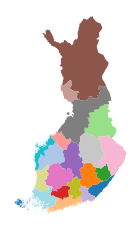

In [41]:
districts.plot(column='healthCareDistrict', scheme="equal_interval",cmap='tab20', k=20)
plt.axis('off')

In [42]:
# Write GeoJSON in original projection
districts.to_file("healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding='utf-8')

In [43]:
# Re-project to WGS84 and save again
wgs84 = CRS.from_epsg(4326)
districts.to_crs(wgs84).to_file("healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding='utf-8')